In [11]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('../xsec.json') as f:
    xs = json.load(f)

with open('../pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

mc = ['QCD', 'ttbar', 'ttH' ,'singlet', 'Wjets','Zjets','VV','EWKZ','EWKW','ggF','VBF','WH','ZH']


#To calculate significance
def significance(s,b):
    if b==0:
        return 0
    #z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return s/b

In [12]:
picklename = "2017_sig_scan/templates.pkl"
templates = pickle.load(open(picklename,'rb'))\
            .integrate('msd1',slice(117.,131.))\
            .integrate('j2pt', slice(200,1200))\
            .integrate('region','signal')

## Cut optimization

In [4]:
def add_significance(s_forward, b_forward, s_backward, b_backward):
    
    forward_sign = significance(s_forward, b_forward)
    backward_sign = significance(s_backward, b_backward)
    
    return np.hypot(forward_sign, backward_sign)

def opt_significance(templates, proc = 'ZH'):

    significance_table = np.zeros((100,100))
    ddb1_thresholds = templates.axis('ddb1').edges()
    ddc2_thresholds = templates.axis('ddc2').edges()
    
    b_list = [x for x in mc if x not in ['ZH', 'WH']] #Background
    
    #Index counter for the main matrix
    i = 0
    for ddb_thres in ddb1_thresholds[:-1]: #ddb1
        
        j = 0
        for ddc_thres in ddc2_thresholds[:-1]: #ddc2
            try:
                # ≥ cuts
                s_forward = templates.integrate('process', proc)\
                             .integrate('ddb1', int_range = slice(ddb_thres,1.))\
                             .integrate('ddc2', int_range = slice(ddc_thres,1.))\
                             .values()[()]

                b_forward = templates.integrate('process', b_list)\
                             .integrate('ddb1', int_range = slice(ddb_thres,1.))\
                             .integrate('ddc2', int_range = slice(ddc_thres,1.))\
                             .values()[()]
                # < cuts
                s_backward = templates.integrate('process', proc)\
                             .integrate('ddb1', int_range = slice(ddb_thres, 1.))\
                             .integrate('ddc2', int_range = slice(0., ddc_thres))\
                             .values()[()]

                b_backward = templates.integrate('process', b_list)\
                             .integrate('ddb1', int_range = slice(ddb_thres,1.))\
                             .integrate('ddc2', int_range = slice(0., ddc_thres))\
                             .values()[()]

                significance_table[i][j] = add_significance(s_forward, b_forward, s_backward, b_backward)
            except:
                print("Triggering faults!! (i,j) = ", (i,j))
                significance_table[i][j] = 0
            
            #ddc index counter
            j += 1
            
        #ddb index counter
        i += 1
        
    return significance_table

In [5]:
scan_vh = opt_significance(templates, proc = ['ZH','WH'])

Triggering faults!! (i,j) =  (34, 0)
Triggering faults!! (i,j) =  (34, 1)
Triggering faults!! (i,j) =  (34, 2)
Triggering faults!! (i,j) =  (34, 3)
Triggering faults!! (i,j) =  (34, 4)
Triggering faults!! (i,j) =  (34, 5)
Triggering faults!! (i,j) =  (34, 6)
Triggering faults!! (i,j) =  (34, 7)
Triggering faults!! (i,j) =  (34, 8)
Triggering faults!! (i,j) =  (34, 9)
Triggering faults!! (i,j) =  (34, 10)
Triggering faults!! (i,j) =  (34, 11)
Triggering faults!! (i,j) =  (34, 12)
Triggering faults!! (i,j) =  (34, 13)
Triggering faults!! (i,j) =  (34, 14)
Triggering faults!! (i,j) =  (34, 15)
Triggering faults!! (i,j) =  (34, 16)
Triggering faults!! (i,j) =  (34, 17)
Triggering faults!! (i,j) =  (34, 18)
Triggering faults!! (i,j) =  (34, 19)
Triggering faults!! (i,j) =  (34, 20)
Triggering faults!! (i,j) =  (34, 21)
Triggering faults!! (i,j) =  (34, 22)
Triggering faults!! (i,j) =  (34, 23)
Triggering faults!! (i,j) =  (34, 24)
Triggering faults!! (i,j) =  (34, 25)
Triggering faults!! (i

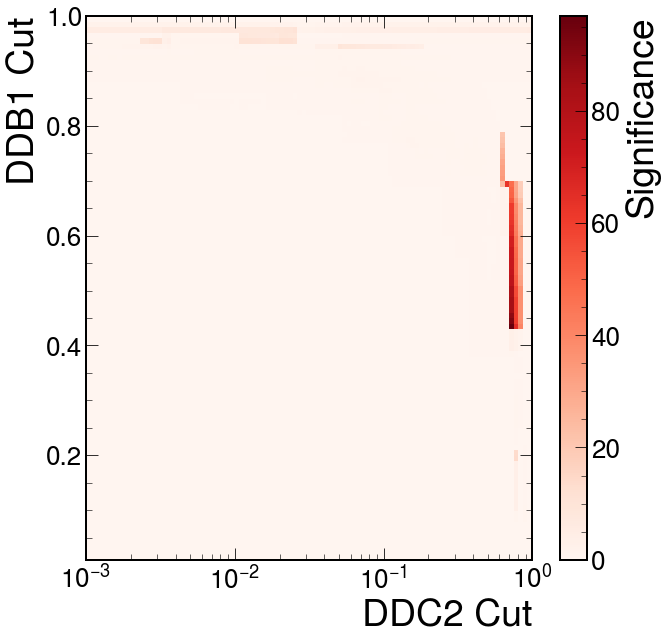

In [6]:
x = templates.axis('ddc2').edges()[1:]
y = templates.axis('ddb1').edges()[1:]

fig, ax = plt.subplots()

ax.set_xscale("log")
pos = ax.pcolor(x,y, scan_vh[1:,1:],cmap = 'Reds')
ax.autoscale('tight')

cbar = plt.colorbar(pos,ax = ax)
cbar.set_label('Significance')

plt.ylabel('DDB1 Cut')
plt.xlabel('DDC2 Cut')

plt.show()

In [7]:
scan_zh = opt_significance(templates, proc = ['ZH'])

Triggering faults!! (i,j) =  (34, 0)
Triggering faults!! (i,j) =  (34, 1)
Triggering faults!! (i,j) =  (34, 2)
Triggering faults!! (i,j) =  (34, 3)
Triggering faults!! (i,j) =  (34, 4)
Triggering faults!! (i,j) =  (34, 5)
Triggering faults!! (i,j) =  (34, 6)
Triggering faults!! (i,j) =  (34, 7)
Triggering faults!! (i,j) =  (34, 8)
Triggering faults!! (i,j) =  (34, 9)
Triggering faults!! (i,j) =  (34, 10)
Triggering faults!! (i,j) =  (34, 11)
Triggering faults!! (i,j) =  (34, 12)
Triggering faults!! (i,j) =  (34, 13)
Triggering faults!! (i,j) =  (34, 14)
Triggering faults!! (i,j) =  (34, 15)
Triggering faults!! (i,j) =  (34, 16)
Triggering faults!! (i,j) =  (34, 17)
Triggering faults!! (i,j) =  (34, 18)
Triggering faults!! (i,j) =  (34, 19)
Triggering faults!! (i,j) =  (34, 20)
Triggering faults!! (i,j) =  (34, 21)
Triggering faults!! (i,j) =  (34, 22)
Triggering faults!! (i,j) =  (34, 23)
Triggering faults!! (i,j) =  (34, 24)
Triggering faults!! (i,j) =  (34, 25)
Triggering faults!! (i

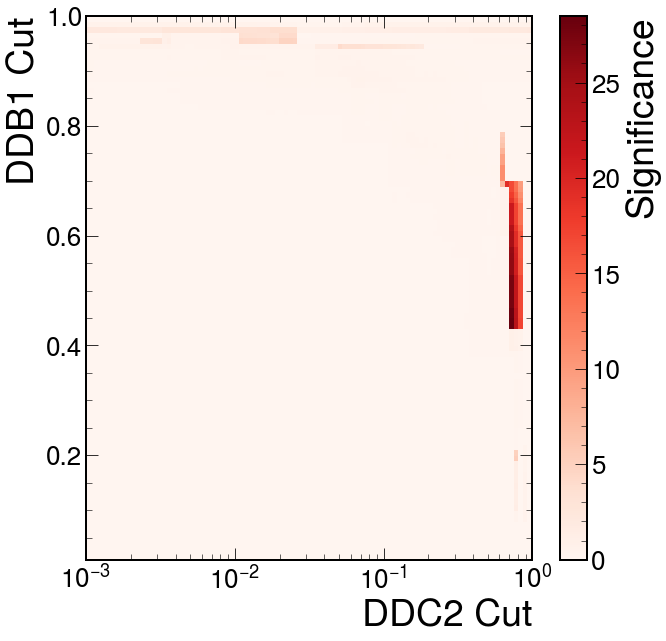

In [8]:
x = templates.axis('ddc2').edges()[1:]
y = templates.axis('ddb1').edges()[1:]

fig, ax = plt.subplots()

ax.set_xscale("log")
pos = ax.pcolor(x,y, scan_zh[1:,1:],cmap = 'Reds')
ax.autoscale('tight')

cbar = plt.colorbar(pos,ax = ax)
cbar.set_label('Significance')

plt.ylabel('DDB1 Cut')
plt.xlabel('DDC2 Cut')

plt.show()

In [9]:
scan_wh = opt_significance(templates, proc = ['WH'])

Triggering faults!! (i,j) =  (34, 0)
Triggering faults!! (i,j) =  (34, 1)
Triggering faults!! (i,j) =  (34, 2)
Triggering faults!! (i,j) =  (34, 3)
Triggering faults!! (i,j) =  (34, 4)
Triggering faults!! (i,j) =  (34, 5)
Triggering faults!! (i,j) =  (34, 6)
Triggering faults!! (i,j) =  (34, 7)
Triggering faults!! (i,j) =  (34, 8)
Triggering faults!! (i,j) =  (34, 9)
Triggering faults!! (i,j) =  (34, 10)
Triggering faults!! (i,j) =  (34, 11)
Triggering faults!! (i,j) =  (34, 12)
Triggering faults!! (i,j) =  (34, 13)
Triggering faults!! (i,j) =  (34, 14)
Triggering faults!! (i,j) =  (34, 15)
Triggering faults!! (i,j) =  (34, 16)
Triggering faults!! (i,j) =  (34, 17)
Triggering faults!! (i,j) =  (34, 18)
Triggering faults!! (i,j) =  (34, 19)
Triggering faults!! (i,j) =  (34, 20)
Triggering faults!! (i,j) =  (34, 21)
Triggering faults!! (i,j) =  (34, 22)
Triggering faults!! (i,j) =  (34, 23)
Triggering faults!! (i,j) =  (34, 24)
Triggering faults!! (i,j) =  (34, 25)
Triggering faults!! (i

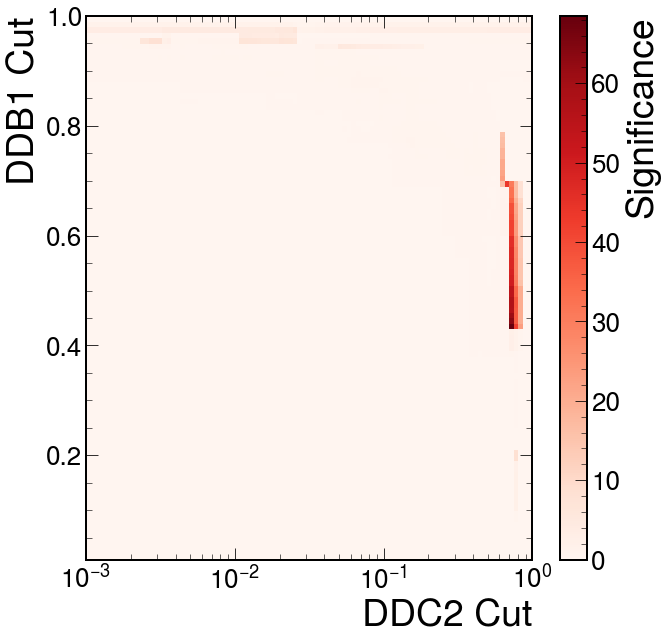

In [10]:
x = templates.axis('ddc2').edges()[1:]
y = templates.axis('ddb1').edges()[1:]

fig, ax = plt.subplots()

ax.set_xscale("log")
pos = ax.pcolor(x,y, scan_wh[1:,1:],cmap = 'Reds')
ax.autoscale('tight')

cbar = plt.colorbar(pos,ax = ax)
cbar.set_label('Significance')

plt.ylabel('DDB1 Cut')
plt.xlabel('DDC2 Cut')

plt.show()

## Check event yeilds

In [16]:
def event_yield(picklename, j2pt_thres = 200):
    
    templates = pickle.load(open(picklename,'rb'))\
            .integrate('msd1',slice(117.,131.))\
            .integrate('j2pt', slice(j2pt_thres,1200))\
            .integrate('region','signal')\
            .sum(*['ddb1', 'ddc2'])
    
    cols = ['Count']
    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        
        df.loc[process, 'Count'] = templates.integrate('process', process).values()[()]


    return df

In [21]:
event_yield(picklename, j2pt_thres = 400)

,Count
QCD,12991.009946352777
ttbar,500.988137123425
ttH,1.0124110819722152
singlet,48.32824371679298
Wjets,423.5077365722211
Zjets,184.59277325064204
VV,6.861783075216906
EWKZ,4.459263033781515
EWKW,19.77446557141104
ggF,2.8974055534094365


## ddc2 cutflow

In [13]:
def event_in_process_larger(picklename, step = 10):
    
    templates = pickle.load(open(picklename,'rb'))\
                  .integrate('msd1',slice(117.,131.))\
                  .integrate('ddb1', slice(0.5,1))\
                  .integrate('region','signal')\
                  .integrate('j2pt', slice(200,1200))\
    
    #New label for columns
    cols = [">={}".format(x) for x in templates.axis('ddc2').edges()][::step]
    edge_vals = templates.axis('ddc2').edges()[::step] #Coresponding edge value to use later

    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        for thres in edge_vals:
            df.loc[process, ">={}".format(thres)] = templates.integrate('process', process).integrate('ddc2', slice(thres,1)).values()[()]
    
    return df

larger_table = event_in_process_larger(picklename, step = 1)

In [14]:
larger_table

,>=0.0,>=0.001,>=0.0010722672220103231,>=0.0011497569953977356,>=0.0012328467394420659,>=0.0013219411484660286,>=0.0014174741629268048,>=0.0015199110829529332,>=0.0016297508346206436,>=0.001747528400007683,...,>=0.5336699231206312,>=0.572236765935022,>=0.6135907273413176,>=0.6579332246575682,>=0.7054802310718645,>=0.7564633275546291,>=0.8111308307896873,>=0.8697490026177834,>=0.9326033468832199,>=1.0
QCD,106.688766,54.043966,53.330357,52.411137,52.361326,51.499318,50.443743,50.316901,48.494878,46.346804,...,0.04606,0.04606,0.04606,0.04606,0.0,0.0,0.0,0.0,0.0,0.0
ttbar,17.741521,17.121062,17.121062,17.121062,16.768394,16.768394,16.678016,16.542746,16.437286,16.437286,...,0.237175,0.130223,0.130223,0.130223,0.0,0.0,0.0,0.0,0.0,0.0
ttH,0.349398,0.329941,0.326612,0.325273,0.325273,0.322402,0.321386,0.317021,0.317021,0.313047,...,0.007081,0.004966,0.002972,0.000986,0.000986,0.000986,0.000986,0.0,0.0,0.0
singlet,1.464044,1.197648,1.197648,1.197648,1.197648,1.197648,1.197648,1.197648,1.197648,1.197648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wjets,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zjets,2.544943,1.792422,1.792422,1.792422,1.666037,1.666037,1.666037,1.666037,1.666037,1.666037,...,0.002508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VV,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EWKZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EWKW,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986,...,0.11612,0.11612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ggF,1.59912,1.335426,1.322862,1.270244,1.270244,1.232007,1.210593,1.131239,1.072939,1.016805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
larger_table.to_csv('csv_outfiles/ddc2_table_larger_0.5ddb.csv')

In [16]:
def event_in_process_smaller(picklename, step = 10):
    
    templates = pickle.load(open(picklename,'rb'))\
                  .integrate('msd1',slice(117.,131.))\
                  .integrate('ddb1', slice(0.5,1))\
                  .integrate('region','signal')\
                  .integrate('j2pt', slice(200,1200))\
    
    #New labels for columns
    cols = ["<{}".format(x) for x in templates.axis('ddc2').edges()][::step][1:]
    edge_vals = templates.axis('ddc2').edges()[::step][1:] #Coresponding edge value to use later

    df = pd.DataFrame(index = mc, columns = cols)
    
    #loop over the processes and ddc2 scores and calcualte the events
    for process in mc:
        for thres in edge_vals:
            df.loc[process, "<{}".format(thres)] = templates.integrate('process', process).integrate('ddc2', slice(0.,thres)).values()[()]
    
    return df

smaller_table = event_in_process_smaller(picklename, step = 1)

In [17]:
smaller_table

,<0.001,<0.0010722672220103231,<0.0011497569953977356,<0.0012328467394420659,<0.0013219411484660286,<0.0014174741629268048,<0.0015199110829529332,<0.0016297508346206436,<0.001747528400007683,<0.001873817422860383,...,<0.5336699231206312,<0.572236765935022,<0.6135907273413176,<0.6579332246575682,<0.7054802310718645,<0.7564633275546291,<0.8111308307896873,<0.8697490026177834,<0.9326033468832199,<1.0
QCD,52.6448,53.358409,54.277629,54.32744,55.189448,56.245023,56.371865,58.193888,60.341961,60.391185,...,106.642706,106.642706,106.642706,106.642706,106.688766,106.688766,106.688766,106.688766,106.688766,106.688766
ttbar,0.620458,0.620458,0.620458,0.973126,0.973126,1.063505,1.198774,1.304235,1.304235,1.332846,...,17.504345,17.611298,17.611298,17.611298,17.741521,17.741521,17.741521,17.741521,17.741521,17.741521
ttH,0.019457,0.022786,0.024124,0.024124,0.026996,0.028012,0.032377,0.032377,0.03635,0.03635,...,0.342317,0.344432,0.346426,0.348412,0.348412,0.348412,0.348412,0.349398,0.349398,0.349398
singlet,0.266397,0.266397,0.266397,0.266397,0.266397,0.266397,0.266397,0.266397,0.266397,0.266397,...,1.464044,1.464044,1.464044,1.464044,1.464044,1.464044,1.464044,1.464044,1.464044,1.464044
Wjets,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060861,...,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586,1.907586
Zjets,0.752521,0.752521,0.752521,0.878905,0.878905,0.878905,0.878905,0.878905,0.878905,0.999667,...,2.542435,2.544943,2.544943,2.544943,2.544943,2.544943,2.544943,2.544943,2.544943,2.544943
VV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415,0.032415
EWKZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EWKW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133866,0.133866,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986,0.249986
ggF,0.263694,0.276258,0.328876,0.328876,0.367113,0.388527,0.467881,0.526181,0.582315,0.65265,...,1.59912,1.59912,1.59912,1.59912,1.59912,1.59912,1.59912,1.59912,1.59912,1.59912


In [18]:
smaller_table.to_csv('csv_outfiles/ddc2_table_smaller_0.5ddb.csv')

## DDC2 cutflow plots

In [57]:
def plot_num_event(picklename, ddb_thres = 0.5, s_list = ['ZH', 'WH'], plt_indx = 40):
    
    templates = pickle.load(open(picklename,'rb'))\
                  .integrate('msd1',slice(117.,131.))\
                  .integrate('region','signal')\
                  .integrate('j2pt', slice(400,1200))\
                  .integrate('ddb1', slice(ddb_thres,1))
    
    b_list = [x for x in mc if x not in ['ZH', 'WH']] #Background
    ddc2_thresholds = templates.axis('ddc2').edges()
    
    num_b_all = []
    num_s_all = []
    
    for ddc_thres in ddc2_thresholds:
        
        num_b_all.append(templates.integrate('process', b_list).integrate('ddc2',slice(ddc_thres,1.)).values()[()])
        num_s_all.append(templates.integrate('process', s_list).integrate('ddc2',slice(ddc_thres,1.)).values()[()])
        
    plt.plot(ddc2_thresholds[-plt_indx:], num_b_all[-plt_indx:], label='Total background')
    plt.plot(ddc2_thresholds[-plt_indx:], num_s_all[-plt_indx:], label='VH')
    
    plt.ylabel('Events')
    plt.xlabel('DDC Threshold')
    plt.plot([],[], 'none', label='DDB > 0.5')
    #plt.xscale('log')
    
    plt.legend()
    plt.show()          

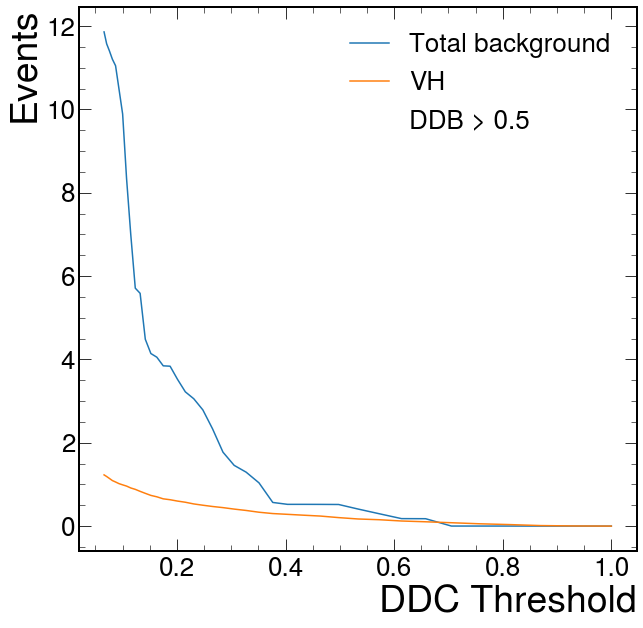

In [58]:
plot_num_event(picklename)

In [75]:
def plot_num_event_less(picklename, ddb_thres = 0.5, s_list = ['ZH', 'WH'], plt_indx = 10):
    
    templates = pickle.load(open(picklename,'rb'))\
                  .integrate('msd1',slice(117.,131.))\
                  .integrate('region','signal')\
                  .integrate('j2pt', slice(400,1200))\
                  .integrate('ddb1', slice(0.,ddb_thres))
    
    b_list = [x for x in mc if x not in ['ZH', 'WH']] #Background
    ddc2_thresholds = templates.axis('ddc2').edges()
    
    num_b_all = []
    num_s_all = []
    
    for ddc_thres in ddc2_thresholds:
        
        num_b_all.append(templates.integrate('process', b_list).integrate('ddc2',slice(ddc_thres,1.)).values()[()])
        num_s_all.append(templates.integrate('process', s_list).integrate('ddc2',slice(ddc_thres,1.)).values()[()])
        
    plt.plot(ddc2_thresholds[-plt_indx:], num_b_all[-plt_indx:], label='Total background')
    plt.plot(ddc2_thresholds[-plt_indx:], num_s_all[-plt_indx:], label='VH')
    
    plt.ylabel('Events')
    plt.xlabel('DDC Threshold')
    plt.plot([],[], 'none', label='DDB < 0.5')
    #plt.xscale('log')
    
    plt.legend()
    plt.show()          

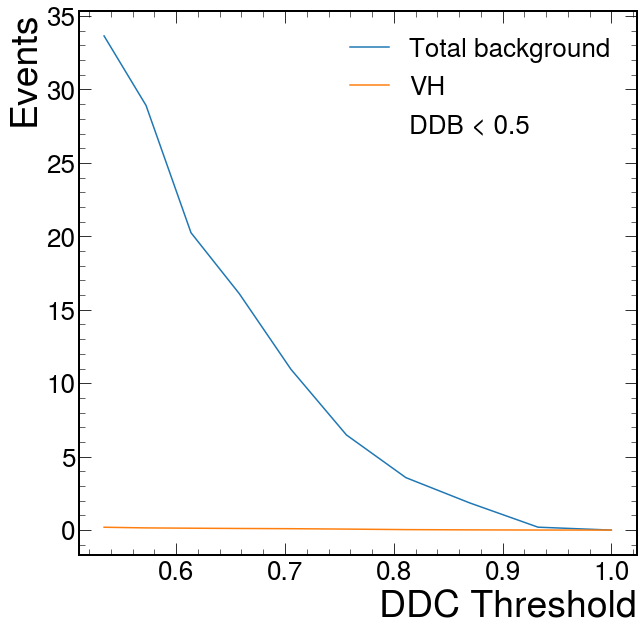

In [76]:
plot_num_event_less(picklename)